In [69]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf
#import cv2
from Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [65]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# Procedurally generated training data
The code below demonstrates how to generate training videos and labels. The function also returns the ground truth particle tracks, which might also be useful depending on your goals.

Note that the training generator is a Tensorflow Module and can be easily incorperated into a Tensorflow neural network. Alternatively, you could simply save a large set of data and use another machine learning framework.

Note that the image dimension is fixed at 256x256. The labels are downsampled to 128x128 in the image dimensions. There are two classes (a particle is detected or not detected) per label so the label shape is 128x128x2. Hence, the neural network output should be 128x128x2.

### Our paper
https://www.pnas.org/content/115/36/9026.short

In [44]:
Nt = 50 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

## Visualizing training videos and labels

In [45]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')


interactive(children=(IntSlider(value=0, description='t', max=49), Checkbox(value=True, description='show_trac…

### Particle tracks

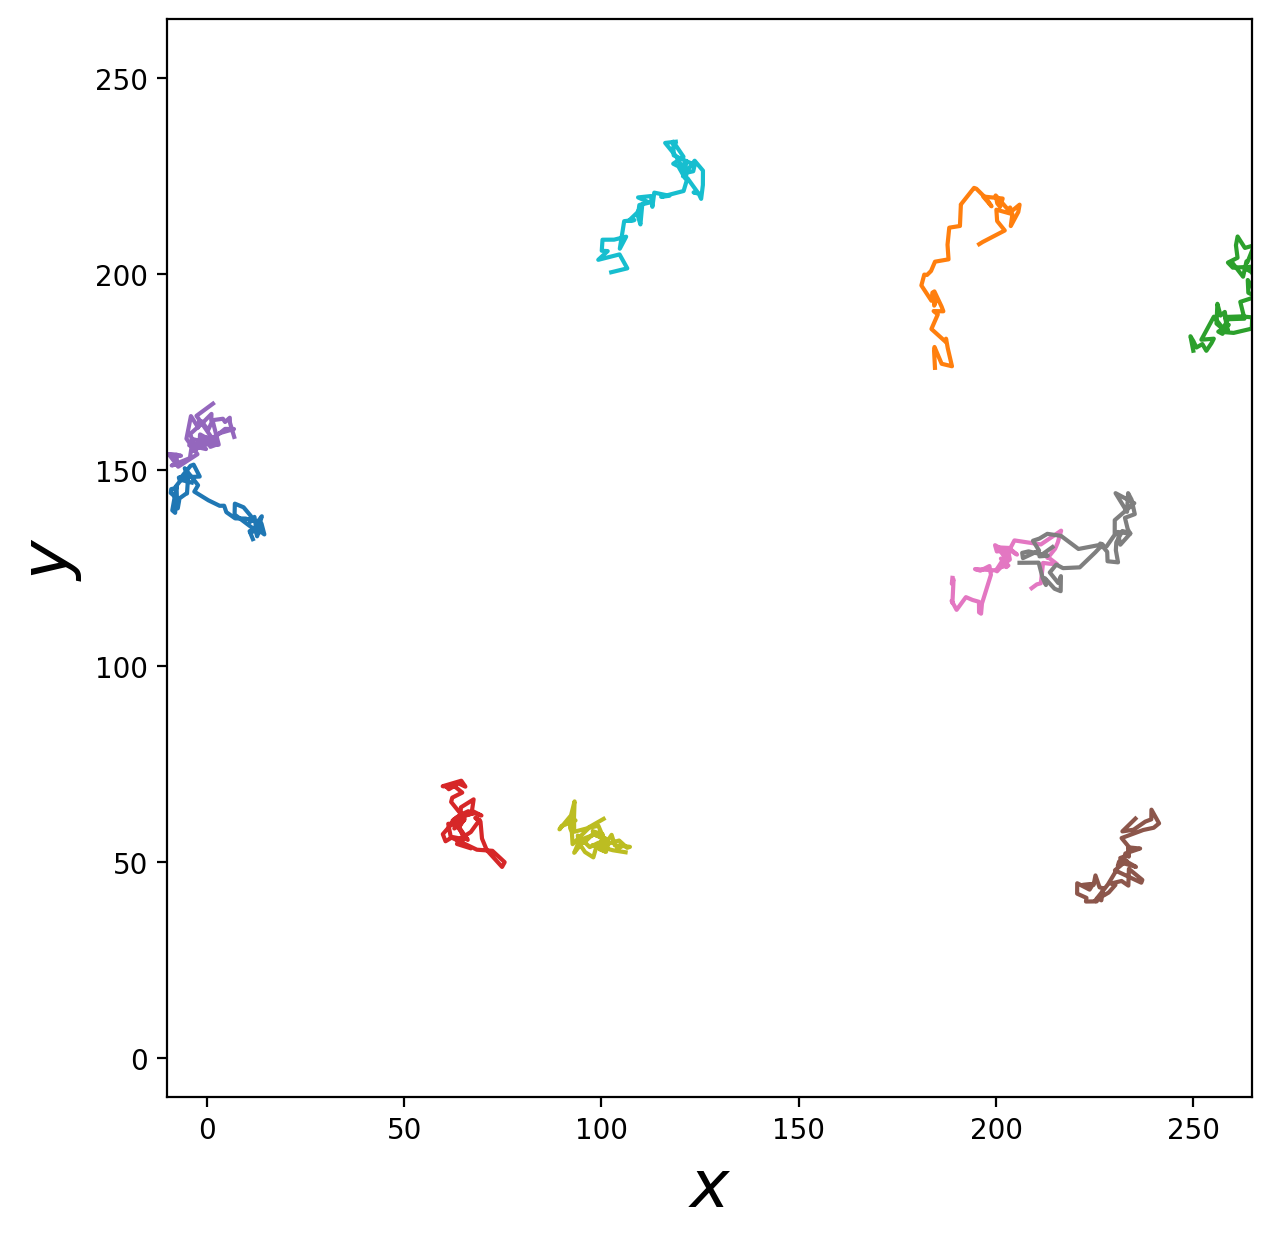

In [112]:
figure(1, [7, 7])
plot(tracks[..., 0], tracks[..., 1])
xlim(-10, 265)
ylim(-10, 265)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

# Goal 1: Design and train a convolutional neural network using the training data generator

(50, 256, 256)
(50, 128, 128)


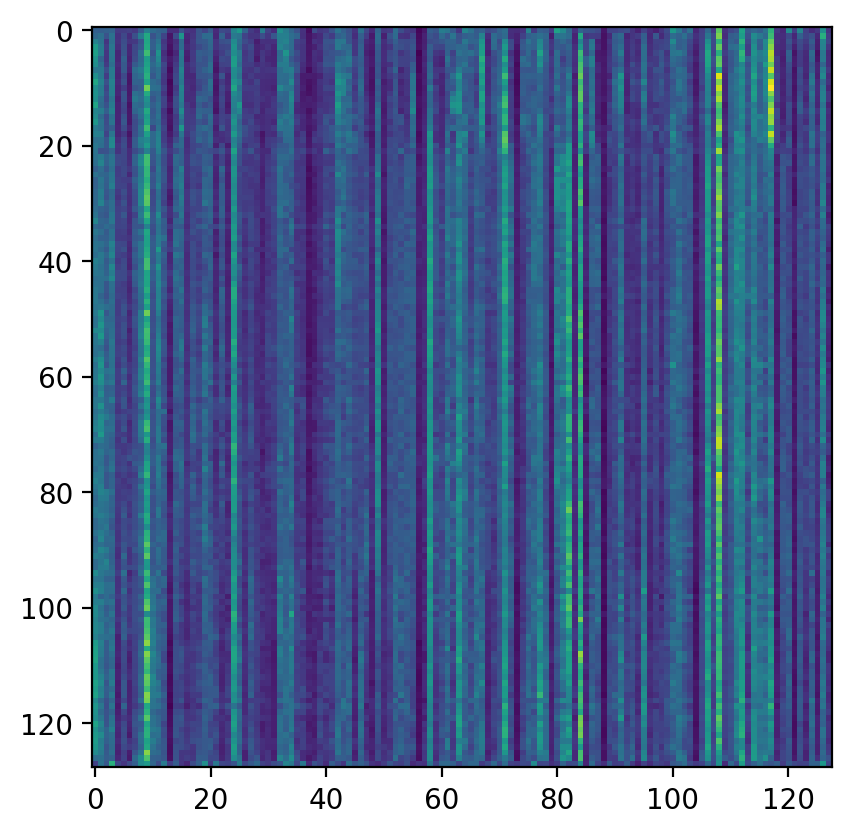

In [32]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()
#tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(64,input_shape=(256,256,1))),
cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(256, 256,1,),padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    #tf.keras.layers.Reshape((128,128)),#1800
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Conv2D(2, (3, 3), activation='relu',padding='same'),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), #input_shape=(5,10)),
    #tf.keras.layers.Reshape((128,128,2)),#1800
    
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='softmax'),
    #tf.keras.layers.Reshape((128,128,2))
    #tf.keras.layers.Lambda(tf.keras.backend.expand_dims(axis=-1)),
])

# Compile the model
cnn_model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
#cnn_model3.summary()
result=cnn_model3(vid)
print(shape(vid))
print(shape(result))
imshow(result[1,...])
#print((result[1,...]))

In [25]:
labels2=labels[...,1]
cnn_model3.fit(vid,labels2, epochs=30)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5402 - loss: 0.6933
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7421 - loss: 0.6044
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8364 - loss: 0.5338
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9103 - loss: 0.4705
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9432 - loss: 0.4085
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9767 - loss: 0.3397
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9959 - loss: 0.2767
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9959 - loss: 0.2194
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9959 - loss: 0.1693
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9959 - loss: 0.1282
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9959 - loss: 0.0962
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9959 - loss: 0.0727
Epoch 13/30
2/2 ━━━━━━━━

KeyboardInterrupt: 

(50, 256, 256)
(50, 128, 128, 2)


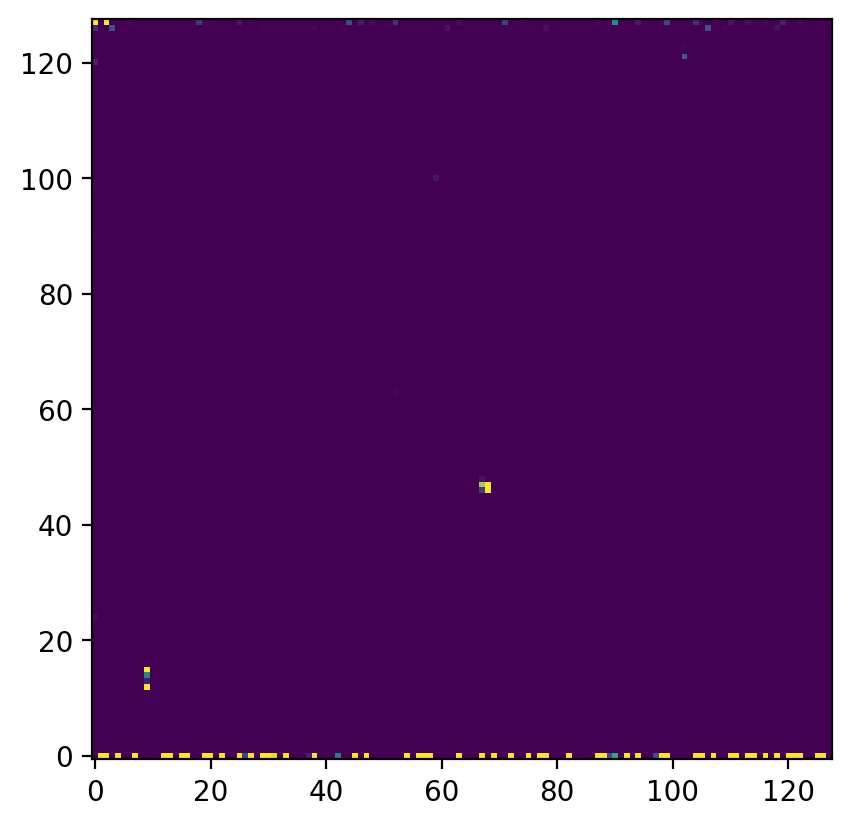

In [46]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()
#tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(64,input_shape=(256,256,1))),
cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(256, 256,1,),padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    #tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(2, (3, 3), activation='relu',padding='same'),
    #tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(64,return_sequences=True)),
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='relu'),
    
    
    #tf.keras.layers.Reshape((128,256)),#1800
    #tf.keras.layers.LSTM(256,return_sequences=True),
    #tf.keras.layers.Reshape((128,128,2)),#1800
    
    
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

# Compile the model
cnn_model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
#cnn_model2.summary()
result=cnn_model2(vid)
print(shape(vid))
print(shape(result))
imshow(result[5,...,1],origin='lower')
#print((result[1,...]))

(50, 256, 256)
(50, 128, 128, 2)


(-10.0, 265.0)

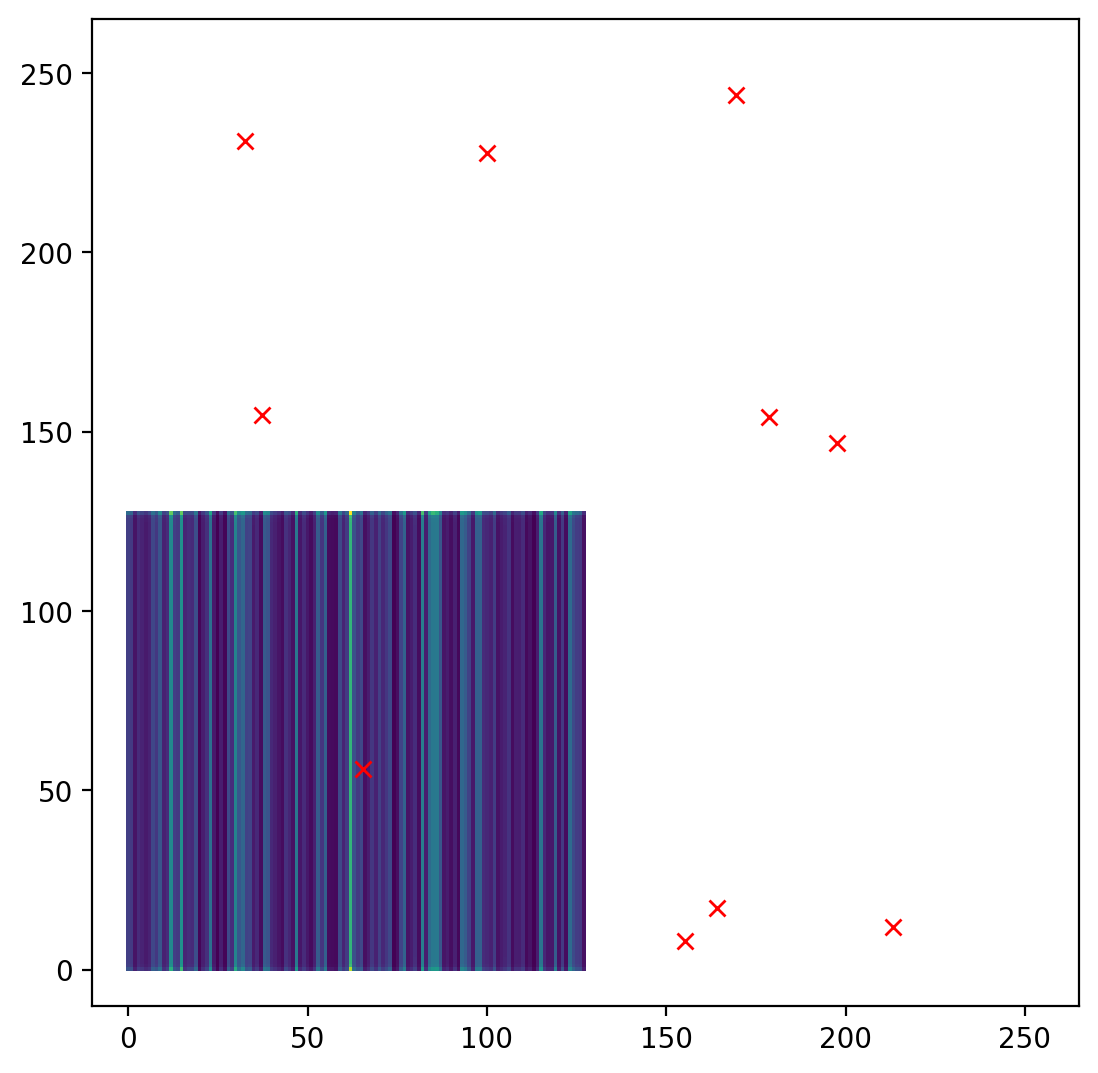

In [26]:
result=cnn_model3(vid)
print(shape(vid))
print(shape(result))
#imshow(result[1,...,1])
#imshow(labels[1,...,1])
t=1
fig = figure(1, [14, 7])
fig.add_subplot(121)
imshow(result[t,...,1], origin='lower')
#if show_tracks:
plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
xlim(-10, 265)
ylim(-10, 265)

In [58]:
#import numpy as np
labels2=labels[...,1]
#print(labels.ndim)
#print(result.ndim)
print(shape(vid))
print(shape(labels2))
cnn_model2.fit(vid,labels2, epochs=50)

(50, 256, 256)
(50, 128, 128)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.9764 - loss: 2.1818
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.9967 - loss: 0.5408
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.9967 - loss: 0.5361
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.9967 - loss: 0.2215
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.9967 - loss: 0.6582
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9967 - loss: 0.6719
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.9967 - loss: 0.6674
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.9967 - loss: 0.6428
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.9967 - loss: 0.3709
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.9967 - loss: 0.1799
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - accuracy: 0.9967 - loss: 0.2458
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286m

(50, 256, 256)
(50, 128, 128, 2)


(-10.0, 265.0)

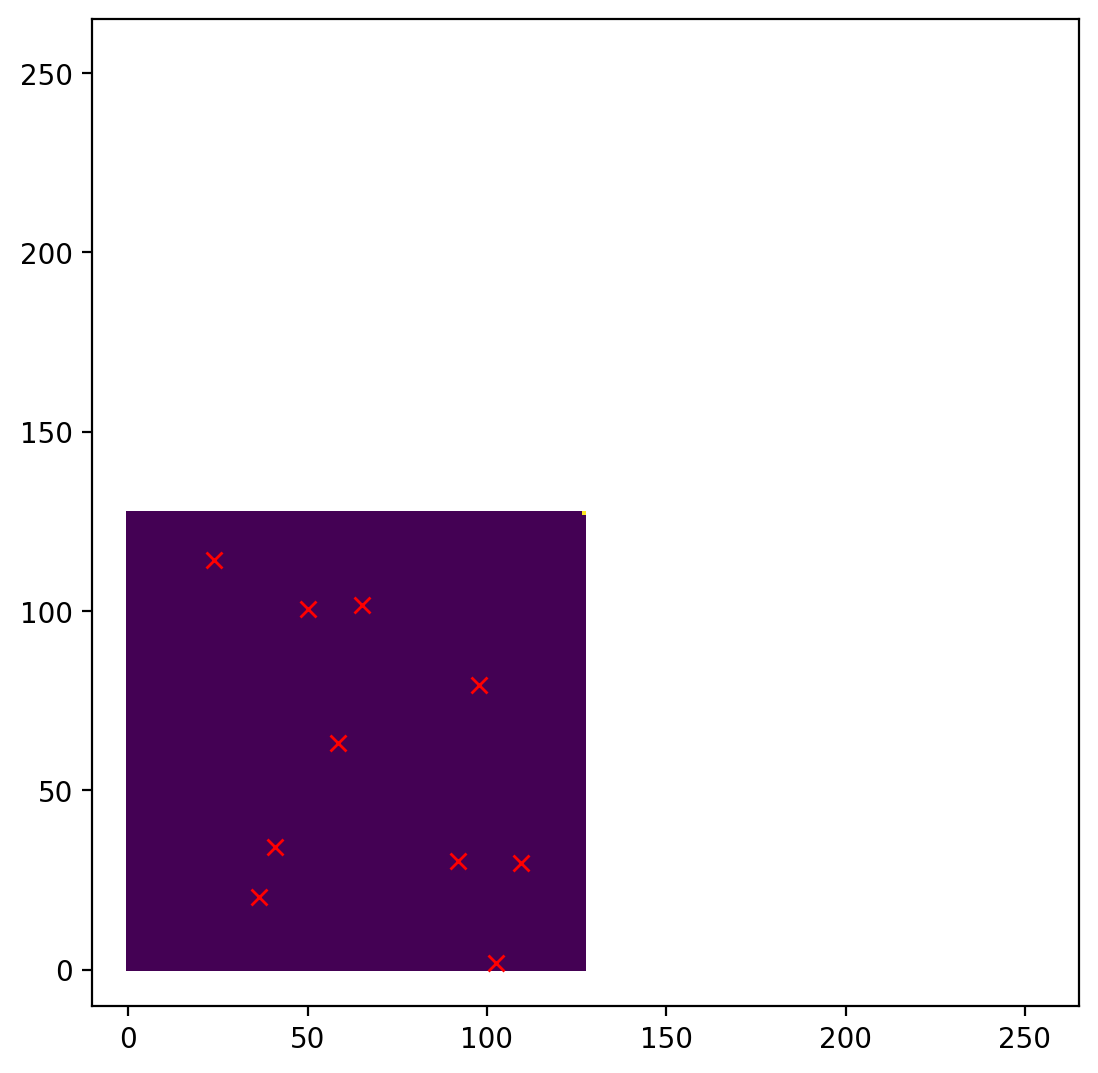

In [6]:
result=cnn_model2(vid)
print(shape(vid))
print(shape(result))
#imshow(result[1,...,1])
#imshow(labels[1,...,1])
t=46
fig = figure(1, [14, 7])
fig.add_subplot(121)
imshow(result[t,...,1], origin='lower')
#if show_tracks:
plot(tracks[t, :, 0]/2, tracks[t, :, 1]/2, 'rx')
xlim(-10, 265)
ylim(-10, 265)

In [75]:
tf.reduce_max(result[t,...,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.44610173>

In [76]:
cnn_model2.save('cnn1.h5')

In [39]:
cnn_test=tf.keras.models.load_model('cnn1.h5')

(50, 256, 256)
(50, 128, 128, 2)


(0.0, 130.0)

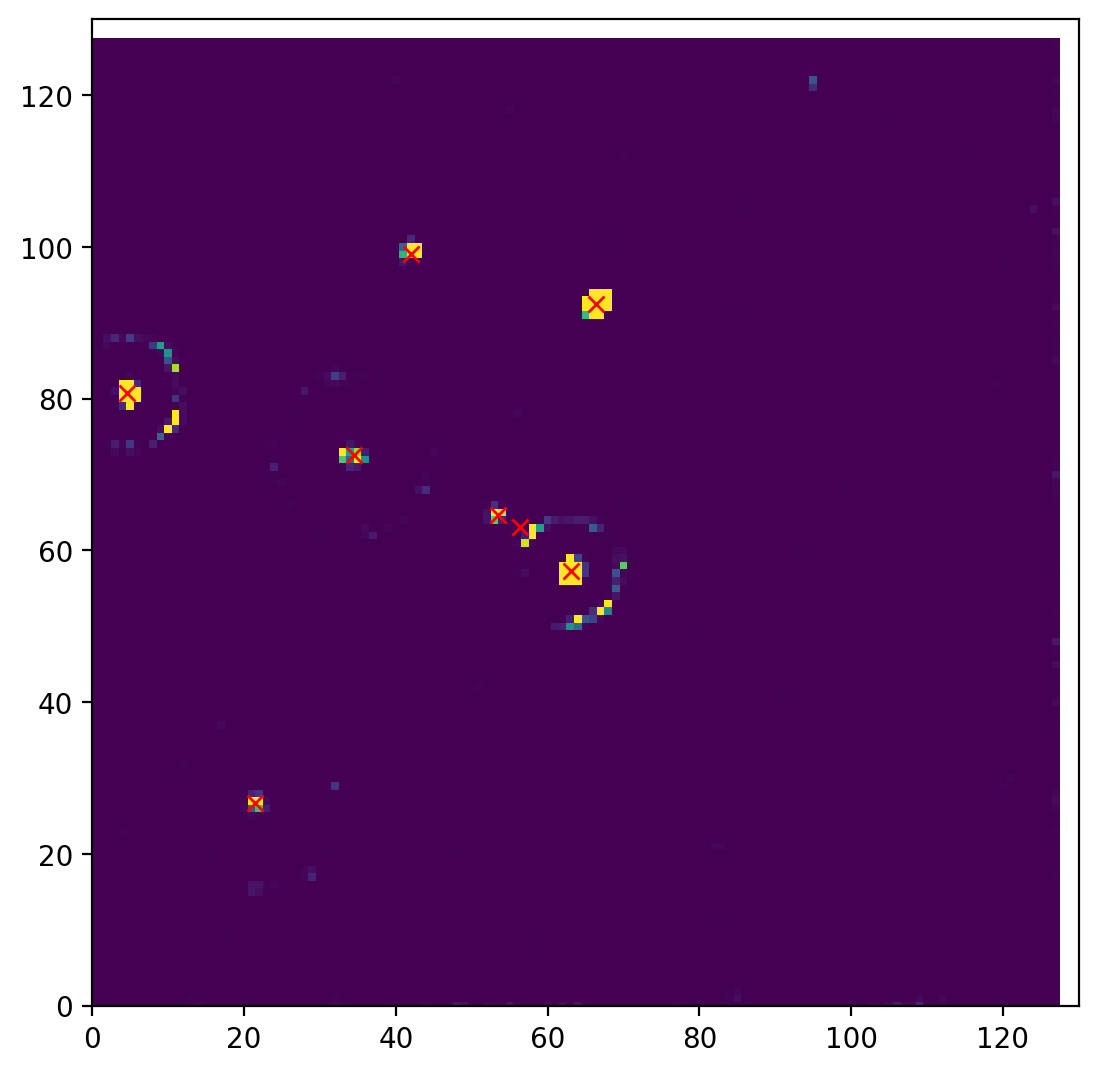

In [49]:
result=cnn_test(vid)
print(shape(vid))
print(shape(result))
#imshow(result[1,...,1])
#imshow(labels[1,...,1])
t=35
fig = figure(1, [14, 7])
fig.add_subplot(121)
imshow(result[t,...,1], origin='lower')
#if show_tracks:
plot(tracks[t, :, 0]/2, tracks[t, :, 1]/2, 'rx')
xlim(0, 130)
ylim(0, 130)

(-10.0, 130.0)

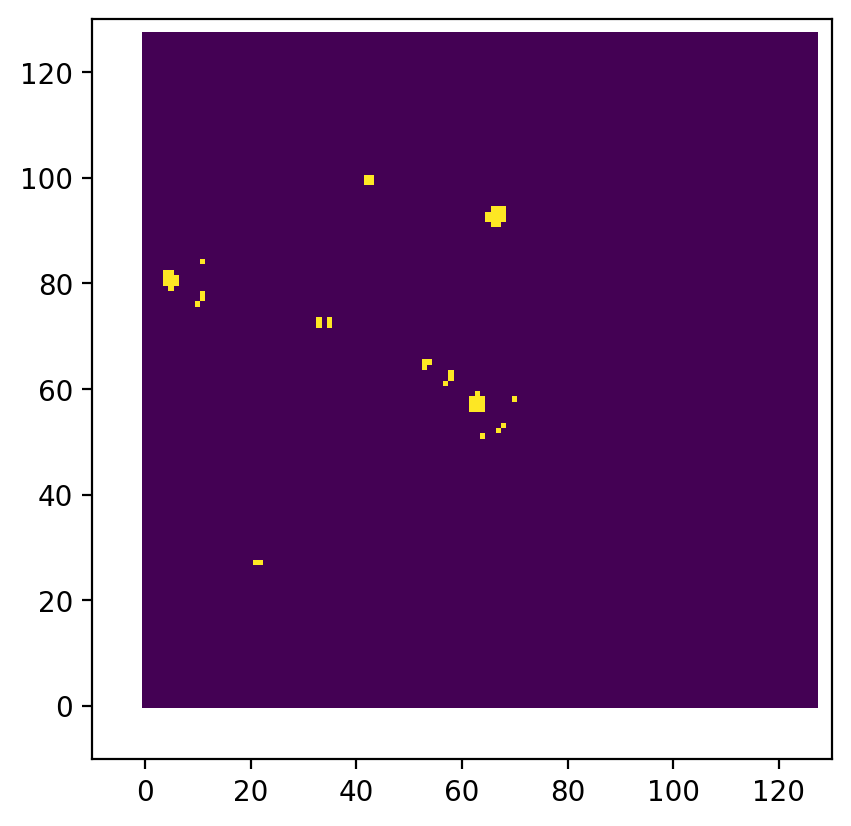

In [53]:
max_1=tf.reduce_max(result[t,...,1])
bi_result=result[t,...,1]>max_1*0.7
imshow(bi_result, origin='lower')
#plot(tracks[t, :, 0]/2, tracks[t, :, 1]/2, 'rx')
xlim(-10, 130)
ylim(-10, 130)

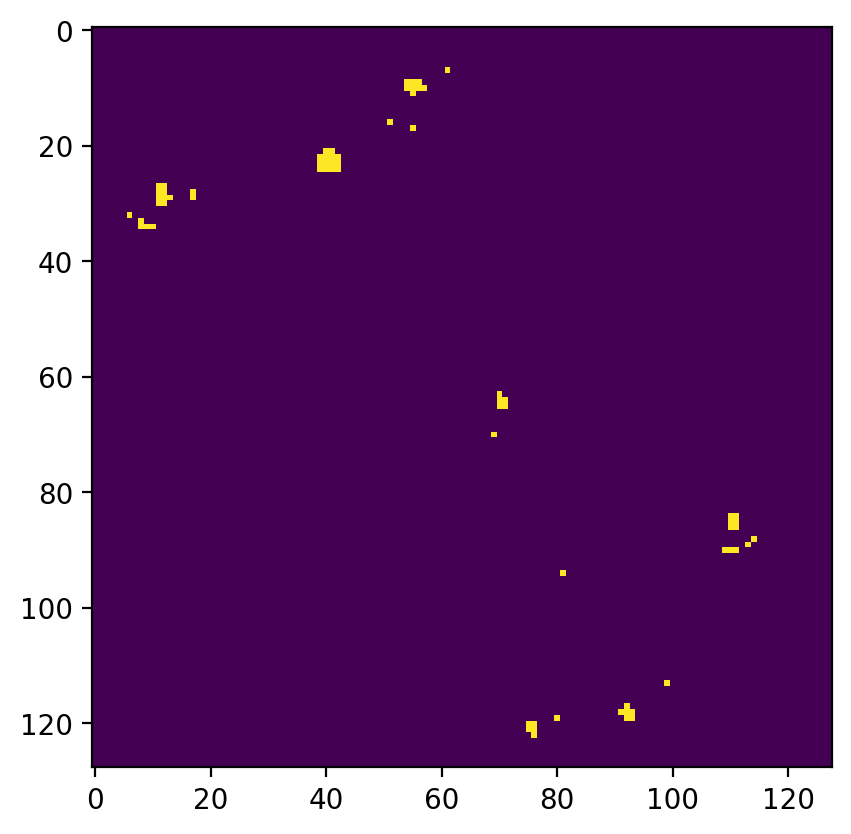

In [10]:
new_bi=np.multiply(bi_result,np.ones([shape(bi_result)[0],shape(bi_result)[1]]))
imshow(new_bi)

In [25]:
particle=[]
width=2
sum=0
for i in range(shape(bi_result)[0]):
    for j in range(width,shape(bi_result)[1]-width+1):
        if bi_result[i,j]==True:
            sum=sum+1
            print(i,j)


11 104
12 105
29 53
30 52
30 53
67 31
68 31
68 32
68 52
68 53
68 54
69 32
69 53
69 54
70 53
70 54
90 101
90 102
103 38
108 31
108 32
108 114
109 31
109 32
109 33
109 113
109 114
109 115
110 113
110 114
110 115
111 113
111 114
111 115


In [62]:
cnn_model2.evaluate(vid,labels2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9959 - loss: 0.0422


[0.041862502694129944, 0.995941162109375]

# Goal 2: Given ground truth labels, extract particle positions in each video frame
Simply stated, given `labels` approximate `tracks`. So this project essentially ignores the training videos.

## Does your method work for hypothetical neural network output?
The neural network output is a probability distribution with values between zero and one.

In [11]:
label_given=new_bi
#label_given=labels[t,...,1]
true_pos=[]
for i in range(shape(label_given)[0]):
    for j in range(shape(label_given)[1]):
        if label_given[i,j]==1:
            true_pos.append([i,j])
true_pos#get positions of true

[[7, 61],
 [9, 54],
 [9, 55],
 [9, 56],
 [10, 54],
 [10, 55],
 [10, 56],
 [10, 57],
 [11, 55],
 [16, 51],
 [17, 55],
 [21, 40],
 [21, 41],
 [22, 39],
 [22, 40],
 [22, 41],
 [22, 42],
 [23, 39],
 [23, 40],
 [23, 41],
 [23, 42],
 [24, 39],
 [24, 40],
 [24, 41],
 [24, 42],
 [27, 11],
 [27, 12],
 [28, 11],
 [28, 12],
 [28, 17],
 [29, 11],
 [29, 12],
 [29, 13],
 [29, 17],
 [30, 11],
 [30, 12],
 [32, 6],
 [33, 8],
 [34, 8],
 [34, 9],
 [34, 10],
 [63, 70],
 [64, 70],
 [64, 71],
 [65, 70],
 [65, 71],
 [70, 69],
 [84, 110],
 [84, 111],
 [85, 110],
 [85, 111],
 [86, 110],
 [86, 111],
 [88, 114],
 [89, 113],
 [90, 109],
 [90, 110],
 [90, 111],
 [94, 81],
 [113, 99],
 [117, 92],
 [118, 91],
 [118, 92],
 [118, 93],
 [119, 80],
 [119, 92],
 [119, 93],
 [120, 75],
 [120, 76],
 [121, 75],
 [121, 76],
 [122, 76]]

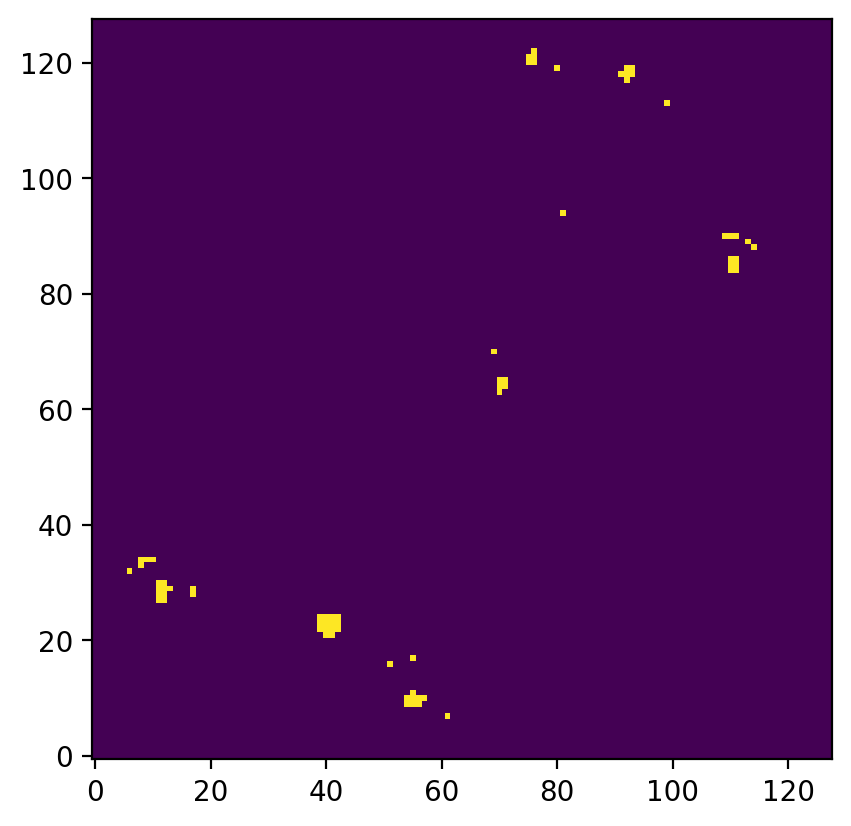

In [19]:
imshow(label_given,origin='lower')

In [83]:
particle=[]
detected=[]
for i in true_pos:
    #add into area that been detected
    if particle==[]:
        particle.append(i)
        #print(i)
    flag_i=0
    for j in particle:
        flag1=0#dfs search
        flag2=0
        #print(j)
        for k in range(min(i[0],j[0]),max(i[0],j[0])):
            if label_given[k,i[1]]==0:
                flag1=1
        for k in range(min(i[1],j[1]),max(i[1],j[1])):
            if label_given[i[0],k]==0:
                flag1=1
        for k in range(min(i[0],j[0]),max(i[0],j[0])):
            if label_given[k,j[1]]==0:
                flag2=1
        for k in range(min(i[1],j[1]),max(i[1],j[1])):
            if label_given[j[0],k]==0:
                flag2=1
    #print(flag1,flag2)
    if flag1==0 or flag2==0:
        flag_i=1

    if flag_i==0:
        particle.append(i)
        #print(i)  

In [84]:
particle

[[7, 61],
 [9, 54],
 [16, 51],
 [17, 55],
 [21, 40],
 [22, 39],
 [27, 11],
 [28, 17],
 [29, 11],
 [29, 17],
 [30, 11],
 [32, 6],
 [33, 8],
 [34, 10],
 [63, 70],
 [70, 69],
 [84, 110],
 [88, 114],
 [89, 113],
 [90, 109],
 [94, 81],
 [113, 99],
 [117, 92],
 [118, 91],
 [119, 80],
 [119, 92],
 [120, 75]]

In [85]:
particle2=particle
for i in particle:
    for j in particle2:
        #print(particle)
        if (abs(i[0]-j[0])+abs(i[1]-j[1]))>0 and (abs(i[0]-j[0])+abs(i[1]-j[1]))<=10:
            particle.remove(j)
for i in particle:
    for j in particle2:
        #print(particle)
        if (abs(i[0]-j[0])+abs(i[1]-j[1]))>0 and (abs(i[0]-j[0])+abs(i[1]-j[1]))<=8:
            particle.remove(j)

In [81]:
particle=array(particle)

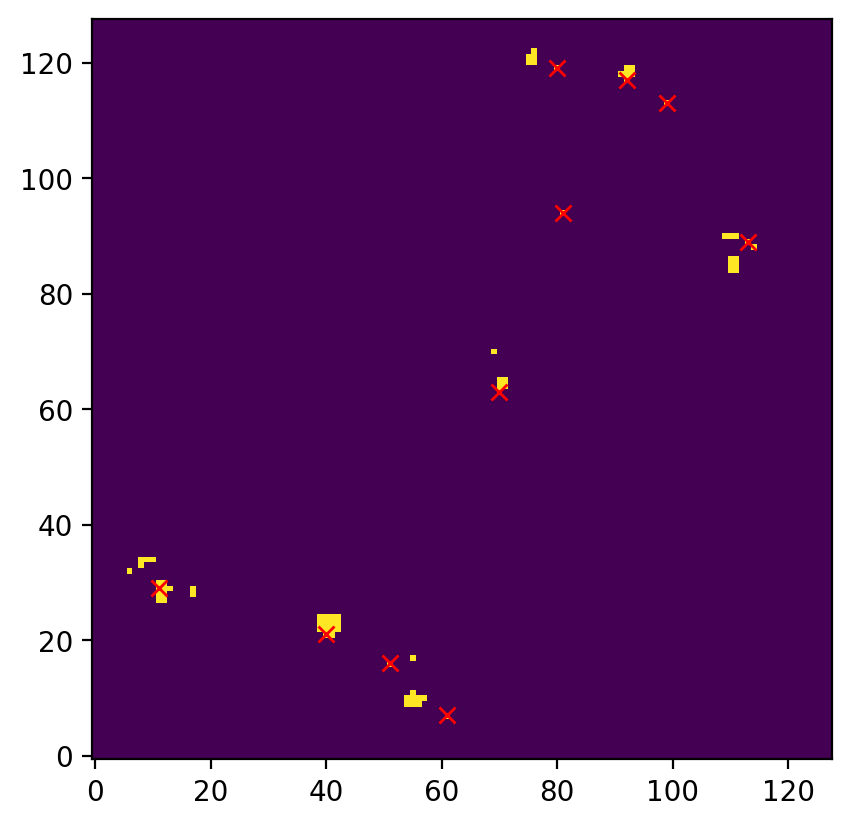

In [82]:
imshow(label_given,origin='lower')
plot(particle[:,1],particle[:,0],'rx')

In [35]:
particle[3]-tracks[t,3,0:2]/2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-81.619064, -73.862045], dtype=float32)>

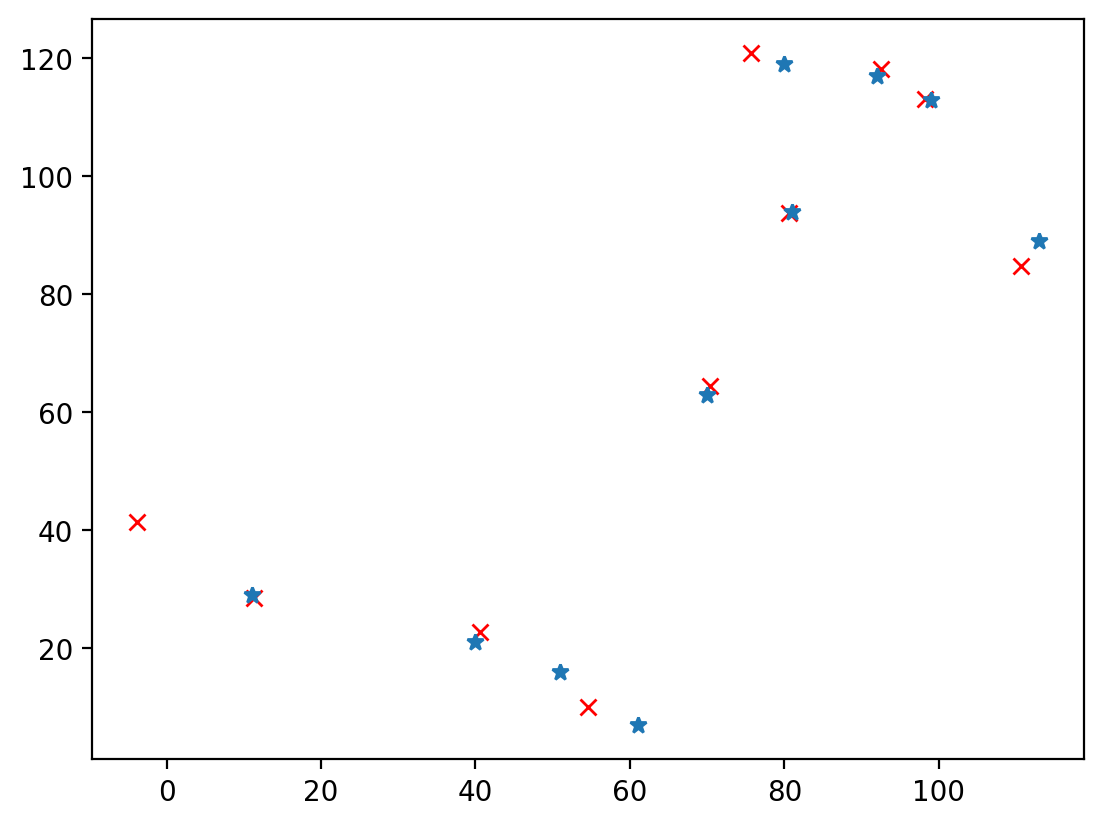

In [57]:
plot(tracks[t,...,0]/2,tracks[t,...,1]/2,'rx',particle[:,1],particle[:,0],'*')

In [123]:
truth0=tracks[t,...,0]/2
truth1=tracks[t,...,1]/2
width_test=10
#test tt
particle_test=particle
tt=0
tf=0
ff=0
ft=0
tot=0
for i in range(10):#truth:
    #print(i)
    flag=0
    for j in particle_test:
        #print(j)
        if particle_test!=[]:
            tot=tot+1
        if (abs(j[0]-truth1[i])+abs(j[1]-truth0[i]))<=width_test:
            flag=1
            #particle_test.remove(j)
    tt=tt+flag

In [124]:
tt

9

In [131]:
truth0=tracks[t,...,0]/2
truth1=tracks[t,...,1]/2
width_test=8
#test tt
particle_test=particle
tt=0
tf=0
ff=0
ft=0
tot=0
for j in particle_test:#truth:
    #print(i)
    tot=tot+1
    flag=0
    for i in range(10):
        #print(j)
        #if particle_test!=[]:
            #tot=tot+1
        if (abs(j[0]-truth1[i])+abs(j[1]-truth0[i]))<=width_test:
            flag=1
            #particle_test.remove(j)
    ff=ff+flag
sn=ff/tot
sn

0.8

In [70]:
#tesing
cnn_test=tf.keras.models.load_model('cnn1.h5')
result2=cnn_test(vid)
tt=0
tf=0
ff=0
ft=0
tot=0
for t in range(50):
    #max_1=tf.reduce_max(result2[t,...,1])
    max1=0.7
    bi_result=result2[t,...,1]>max_1*0.7
    new_bi=np.multiply(bi_result,np.ones([shape(bi_result)[0],shape(bi_result)[1]]))
    label_given=new_bi
    #label_given=labels[t,...,1]
    true_pos=[]
    for i in range(shape(label_given)[0]):
        for j in range(shape(label_given)[1]):
            if label_given[i,j]==1:
                true_pos.append([i,j])
                
    particle=[]
    detected=[]
    for i in true_pos:
    #add into area that been detected
        if particle==[]:
            particle.append(i)
        #print(i)
        flag_i=0
        for j in particle:
            flag1=0#dfs search
            flag2=0
            #print(j)
            for k in range(min(i[0],j[0]),max(i[0],j[0])):
                if label_given[k,i[1]]==0:
                    flag1=1
            for k in range(min(i[1],j[1]),max(i[1],j[1])):
                if label_given[i[0],k]==0:
                    flag1=1
            for k in range(min(i[0],j[0]),max(i[0],j[0])):
                if label_given[k,j[1]]==0:
                    flag2=1
            for k in range(min(i[1],j[1]),max(i[1],j[1])):
                if label_given[j[0],k]==0:
                    flag2=1
        #print(flag1,flag2)
        if flag1==0 or flag2==0:
            flag_i=1

        if flag_i==0:
            particle.append(i)
        #print(i)  
    particle2=particle
    for i in particle:
        for j in particle2:
        #print(particle)
            if (abs(i[0]-j[0])+abs(i[1]-j[1]))>0 and (abs(i[0]-j[0])+abs(i[1]-j[1]))<=10:
                particle.remove(j)
    for i in particle:
        for j in particle2:
        #print(particle)
            if (abs(i[0]-j[0])+abs(i[1]-j[1]))>0 and (abs(i[0]-j[0])+abs(i[1]-j[1]))<=8:
                particle.remove(j)
    
    truth0=tracks[t,...,0]/2
    truth1=tracks[t,...,1]/2
    width_test=10
    #test tt
    particle_test=particle
    
    for i in range(10):#truth:
    #print(i)
        flag=0
        for j in particle_test:
        #print(j)
            #if particle_test!=[]:
                #tot=tot+1
            if (abs(j[0]-truth1[i])+abs(j[1]-truth0[i]))<=width_test:
                flag=1
            #particle_test.remove(j)
        tt=tt+flag
    
    width_test=8
    #test tt
    
    for j in particle_test:#truth:
    #print(i)
        tot=tot+1
        flag=0
        for i in range(10):
        #print(j)
        #if particle_test!=[]:
            #tot=tot+1
            if (abs(j[0]-truth1[i])+abs(j[1]-truth0[i]))<=width_test:
                flag=1
            #particle_test.remove(j)
        ff=ff+flag

In [75]:
print(tt/tot)
print(ff/tot)
#sp=0.9779735682819384
#sn=0.8744493392070485
#acc=0.8524229074889867
print((tt-tot+ff)/tot)

0.9779735682819384
0.8744493392070485
0.8524229074889867


# Goal 3: Given a video and particle positions (from the training data generator) develop a neural network to estimate the z-position of each particle
This one is somewhat speculative. It should be possible, but I have not tried it myself.

In [237]:
particle_x=tracks[...,0]
particle_y=tracks[...,1]
light=tf.Variable(tracks[0:50,0:10,1])
width_window=2
tracks_int=floor(tracks)
for i in range(50):
    pic_t=vid[i,...]
    for j in range(10):
        #window=pic_t[max(tracks[i,j,0]-width_window,0):tracks[i,j,0]+width_window,max(tracks[i,j,1]-width_window,0):tracks[i,j,1]+width_window]
        window=pic_t[int(max(tracks_int[i,j,0]-width_window,0)):int(tracks_int[i,j,0]+width_window),...][...,int(max(tracks_int[i,j,1]-width_window,0)):int(tracks_int[i,j,1]+width_window)]
        light[i,j].assign(sum(window))

In [261]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()
#tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(64,input_shape=(256,256,1))),
lstm_model2 = tf.keras.Sequential([
    tf.keras.layers.Reshape((10,1)),
    #tf.keras.layers.LSTM(64,return_sequences=True,input_shape=(50,10,1)),
   
    
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    #tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(2, activation='tanh'),
    
])

# Compile the model
lstm_model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
#cnn_model2.summary()
result=lstm_model2(light)

In [262]:
z_label=(tracks[...,2]-tf.reduce_min(tracks[...,2]))/(tf.reduce_max(tracks[...,2])-tf.reduce_min(tracks[...,2]))

In [263]:
result

<tf.Tensor: shape=(50, 10, 2), dtype=float32, numpy=
array([[[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],

In [264]:
lstm_model2.fit(light,z_label, epochs=50)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - loss: 16.0253  
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 16.0253  
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 16.0253  
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 16.0253 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 16.0253
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 16.0253  
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 16.0253 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 16.0253  
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 16.0253 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 16.0253  
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 16.0253 
Epoch 12/50
2/2 ━━━━━━━━━━━━━

In [265]:
result_z=lstm_model2(light)
result_z

<tf.Tensor: shape=(50, 10, 2), dtype=float32, numpy=
array([[[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]],

       [[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],

In [260]:
z_label

<tf.Tensor: shape=(50, 10), dtype=float32, numpy=
array([[7.02891707e-01, 8.29363227e-01, 1.99354172e-01, 9.49728549e-01,
        5.41202664e-01, 8.56997967e-01, 1.52669057e-01, 9.52681661e-01,
        2.06150841e-02, 4.95782286e-01],
       [6.30597413e-01, 8.59633625e-01, 1.60850704e-01, 9.90394652e-01,
        5.63845992e-01, 8.73143852e-01, 1.88407481e-01, 9.95133817e-01,
        9.40984562e-02, 4.65330333e-01],
       [6.20901942e-01, 8.20509613e-01, 1.71612933e-01, 9.87942517e-01,
        6.02413833e-01, 8.44340503e-01, 2.72602320e-01, 9.63567674e-01,
        1.15561724e-01, 4.97064501e-01],
       [6.47435904e-01, 8.20239186e-01, 1.04601406e-01, 9.87872243e-01,
        5.84319592e-01, 8.44813049e-01, 3.13000858e-01, 9.12880003e-01,
        1.59029946e-01, 5.01807928e-01],
       [6.30050242e-01, 8.66227746e-01, 5.63427992e-02, 9.93973494e-01,
        6.65414035e-01, 8.63964140e-01, 3.92752916e-01, 9.15709674e-01,
        1.17713802e-01, 5.51489353e-01],
       [6.42686129e-01, 8

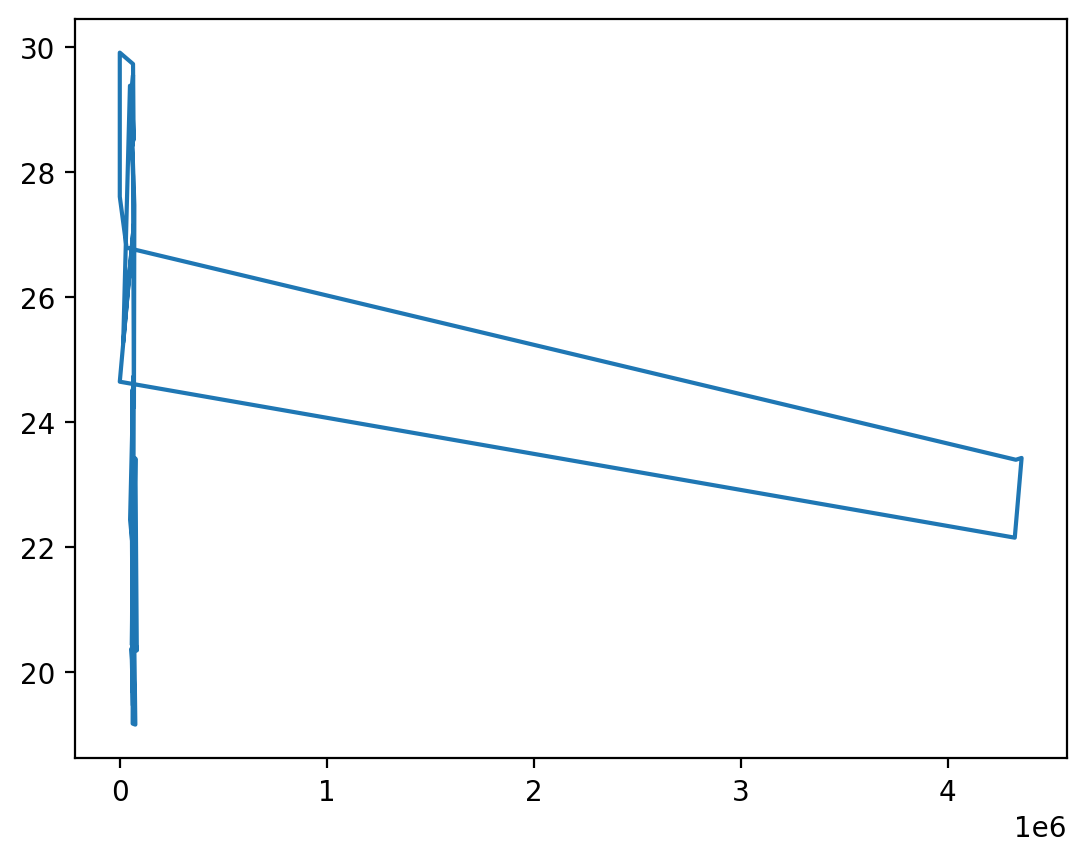

In [238]:
plot(light[...,1],tracks[...,2][...,1])